# Completeness and correctness

## Overall purpose and objective
The overall purpose and objective of the cleaning and verification process is to prepare the data for conversion into a SQLite database (Datasette). As such, the data should follow database best practices.

## Specific purpose of this notebook
This notebook is for checking the completeness and correctness of the information in the data. Specifically, we want to look for:
- NULL, blank, or missing values
- "#ERROR!" values as these might indicate mistakes in the spreadsheet > there is an expected value but it is not computed correctly
- Text (or strings) in fields that should be numbers

These issues were reviewed per table, per country, and per column/field.

## Assumptions
- There should be no blank values in the dataset. Each cell should be explicit in its value/meaning. For example:
    - if a field (e.g. revenue) is 0, it should have a value of 0 in the cell and not NULL/blank
    - if a field (e.g. website) is not applicable, it should say 'not applicable' and not be NULL/blank
- The type of data within rows should be consistent
- Data entry procedures have been consistently followed, minimizing the likelihood of unexpected or incorrect values.
- The dataset is assumed to have undergone rigorous data validation checks to identify and address any missing or erroneous values.
- Cell values are expected to fall within valid and meaningful ranges

## Why this matters
- Blanks or NULLs can have different meanings, specially when viewed by different users. The purpose of the database is to be as explicit as possible as to meaning of the data. This means following a standard and strict taxonomy of values. It should be properly documented what 'not applicable', 'not available', 'not communicated', etc. mean.
- By following this taxonomy, the resulting database is also kept clean and consistent.

## Findings
In general:
1. Most of the issues when it comes to the completeness and correctness are in the following tables:
    - Part 3 - Reporting companies' list
    - Part 3 - Reporting projects' list
    - Part 5 - Company data
2. The top 5 countries with the most issues (NULLS/blanks, #ERROR!, etc.) are:
    - Ukraine (21134)
    - Mongolia (14287)
    - United Kingdom (11191)
    - Afghanistan (10407)
    - Nigeria (9395)
3. The top 5 countries with the highest percentage of issues are:
    - Seychelles (0.0125% , 83/665812)
    - Guatemala (0.0045%, 66/1525558)
    - Mexico (0.0012%, 2712/223936076)
    - Germany (0.0012%, 1140/94668624)
    - Cameroon, (0.0012%, 982/81747570)
5. The mostcommon type of issue are missing values (NULLS/blanks)
6. Some reports are missing Part 3 - Reporting projects' list and 1 report is missing Part 5 - Company data

More specific findings are discussed below.

## Analysis

In [1]:
# import libraries and data

import pandas as pd
import numpy as np
from os import path
from functools import reduce
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

file_dir = "data/consolidated/"

# load the csvs into data frames
df_part_1 = pd.read_csv(path.join(file_dir, "Part 1 - About.csv"))
df_part_3a = pd.read_csv(path.join(file_dir, "Part 3 - Reporting companies' list.csv"))
df_part_3b = pd.read_csv(path.join(file_dir, "Part 3 - Reporting government entities list.csv"))
df_part_3c = pd.read_csv(path.join(file_dir, "Part 3 - Reporting projects' list.csv"))
df_part_4 = pd.read_csv(path.join(file_dir, "Part 4 - Government revenues.csv"))
df_part_5 = pd.read_csv(path.join(file_dir, "Part 5 - Company data.csv"))
# df_part_5 = pd.read_csv(path.join(file_dir, "Part 5 - Company data.csv"), low_memory=False)

df_list = [df_part_1, df_part_3a, df_part_3b, df_part_3c, df_part_4, df_part_5]
df_dict = {"Part 1 - About.csv": df_part_1,
           "Part 3 - Reporting companies' list.csv": df_part_3a,
           "Part 3 - Reporting government entities list.csv": df_part_3b,
           "Part 3 - Reporting projects' list.csv": df_part_3c,
           "Part 4 - Government revenues.csv": df_part_4,
           "Part 5 - Company data.csv": df_part_5
          }

# OPTIONAL COLUMNS
part_3a_opt = ["Stock exchange listing or company website", 
               "Audited financial statement (or balance sheet, cash flows, profit/loss statement if unavailable)"]
part_3b_opt = ["ID number (if applicable)"]
part_5_opt = ["In-kind volume (if applicable)", "Unit (if applicable)", "Comments"]

# only include fields that are non-optional
df_part_1_non_opt = df_part_1.copy()
df_part_3a_non_opt = df_part_3a.copy().drop(columns=part_3a_opt)               
df_part_3b_non_opt = df_part_3b.copy().drop(columns=part_3b_opt)
df_part_3c_non_opt = df_part_3c.copy()
df_part_4_non_opt = df_part_4.copy()
df_part_5_non_opt = df_part_5.copy().drop(columns=part_5_opt)

df_list_non_opt = [df_part_1_non_opt, df_part_3a_non_opt, df_part_3b_non_opt, df_part_3c_non_opt, df_part_4_non_opt, df_part_5_non_opt]
df_dict_non_opt = {"Part 1 - About.csv": df_part_1_non_opt,
           "Part 3 - Reporting companies' list.csv": df_part_3a_non_opt,
           "Part 3 - Reporting government entities list.csv": df_part_3b_non_opt,
           "Part 3 - Reporting projects' list.csv": df_part_3c_non_opt,
           "Part 4 - Government revenues.csv": df_part_4_non_opt,
           "Part 5 - Company data.csv": df_part_5_non_opt
          }

### Not all countries are represented in the tables
#### IMPLICATIONS
- some reports do not include all tables

#### RESULTS
- 8 countries ('Democratic Republic of Congo', 'Ethiopia', 'Nigeria', 'Norway', 'Suriname', 'Tanzania', 'Togo') are not in Part 3 - Reporting projects' list
- 2 countries ('Guatemala', 'Seychelles') are not in Part 5 - Company data
- Guatemala is in Part 3 - Reporting projects' list but not in Part 5 - Company data

In [2]:
df_part_1["Country or area name"].nunique()

for table in df_dict:
    field = "Country"
    if table == "Part 1 - About.csv":
        field = "Country or area name"
    print(f'{table}: {df_dict[table][field].nunique()} countries')

Part 1 - About.csv: 37 countries
Part 3 - Reporting companies' list.csv: 37 countries
Part 3 - Reporting government entities list.csv: 37 countries
Part 3 - Reporting projects' list.csv: 29 countries
Part 4 - Government revenues.csv: 37 countries
Part 5 - Company data.csv: 35 countries


In [3]:
c_part_1 = pd.DataFrame(df_part_1["Country or area name"].unique())
c_part_3a = pd.DataFrame(df_part_3a["Country"].unique())
c_part_3b = pd.DataFrame(df_part_3b["Country"].unique())
c_part_3c = pd.DataFrame(df_part_3c["Country"].unique())
c_part_4 = pd.DataFrame(df_part_4["Country"].unique())
c_part_5 = pd.DataFrame(df_part_5["Country"].unique())

In [4]:
c_part_1.rename(columns={0: "Country"}, inplace=True)
c_part_3a.rename(columns={0: "Country"}, inplace=True)
c_part_3b.rename(columns={0: "Country"}, inplace=True)
c_part_3c.rename(columns={0: "Country"}, inplace=True)
c_part_4.rename(columns={0: "Country"}, inplace=True)
c_part_5.rename(columns={0: "Country"}, inplace=True)

In [5]:
def compare_fields_in_tables(table1, table2, fieldname):

    merged = pd.merge(table1, table2, on=fieldname, how="outer", indicator=True)

    return {f'{fieldname} in Table 1 not in Table 2': merged[merged["_merge"] == "left_only"][fieldname].tolist(),
            f'{fieldname} in Table 2 not in Table 1': merged[merged["_merge"] == "right_only"][fieldname].tolist()}

In [6]:
countries_ab = compare_fields_in_tables(c_part_3c, c_part_5, "Country")
for x in countries_ab:
    print(f'{x}: {countries_ab[x]}')

Country in Table 1 not in Table 2: ['Guatemala']
Country in Table 2 not in Table 1: ['Democratic Republic of Congo', 'Ethiopia', 'Nigeria', 'Norway', 'Suriname', 'Tanzania', 'Togo']


### Number of issues in the table

#### RESULTS
- When we include ALL columns:
    - ~18% of cells across all tables are NULL/blank
        - Part 3 - Reporting projects' list and Part 5 - Company data both have 18% NULL values
    - <1% of cells across all tables are #ERROR!
        - Part 1 - About, Part 3 - Reporting companies' list, and Part 3 - Reporting government entities list have >2% #ERROR! values

---

- If we only include NON-OPTIONAL columns:
    - ~9% of required cells across all tables are NULL/blank
        - Part 3 - Reporting projects' list still has 18% NULL values
        - Part 5 - Company data only has 8% NULL values
    - <1% of cells across all tables are #ERROR!
        - Part 1 - About, Part 3 - Reporting companies' list, and Part 3 - Reporting government entities list have >2% 

In [7]:
def count_number_of_issues_per_table(table_dict):
    table_info_list = []

    for table_name, table_data in table_dict.items():
        num_cells = table_data.size
        null_counts = table_data.isnull().sum().sum()
        error_counts = (table_data == "#ERROR!").sum().sum()
        null_perc = 100*null_counts/num_cells
        error_perc = 100*error_counts/num_cells
        
        # error_counts = table_data.map(lambda x: str(x).count('#ERROR!')).sum().sum()
        table_info_list.append({"Table": table_name, "Number of cells": table_data.size, 
                                "NULL": null_counts, "% NULL": round(null_perc, 2), 
                                "#ERROR!": error_counts, "% #ERROR!": round(error_perc, 2)})
    
    # Convert the list of dictionaries into a DataFrame
    return pd.DataFrame(table_info_list)

In [8]:
print("Number of issues per table (ALL COLUMNS)")
count_number_of_issues_per_table(df_dict)

Number of issues per table (ALL COLUMNS)


,Table,Number of cells,NULL,% NULL,#ERROR!,% #ERROR!
0,Part 1 - About.csv,2886,268,9.29,59,2.04
1,Part 3 - Reporting companies' list.csv,49842,5478,10.99,993,1.99
2,Part 3 - Reporting government entities list.csv,4941,420,8.50,137,2.77
3,Part 3 - Reporting projects' list.csv,87402,16388,18.75,117,0.13
4,Part 4 - Government revenues.csv,25377,358,1.41,0,0.00
5,Part 5 - Company data.csv,560541,104708,18.68,44,0.01


The table below shows the total count of issues if we remove optional columns.

In [9]:
print("Number of issues per table (NON-OPTIONAL COLUMNS ONLY)")
count_number_of_issues_per_table(df_dict_non_opt)

Number of issues per table (NON-OPTIONAL COLUMNS ONLY)


,Table,Number of cells,NULL,% NULL,#ERROR!,% #ERROR!
0,Part 1 - About.csv,2886,268,9.29,59,2.04
1,Part 3 - Reporting companies' list.csv,42174,1263,2.99,993,2.35
2,Part 3 - Reporting government entities list.csv,4392,83,1.89,137,3.12
3,Part 3 - Reporting projects' list.csv,87402,16388,18.75,117,0.13
4,Part 4 - Government revenues.csv,25377,358,1.41,0,0.00
5,Part 5 - Company data.csv,461622,34945,7.57,0,0.00


In [10]:
df = count_number_of_issues_per_table(df_dict).copy()

weighted_avg_nulls = (df['Number of cells'] * df['NULL']).sum() / df['Number of cells'].sum()
weighted_avg_percent_nulls = (df['NULL'] / df['Number of cells'] * 100 * df['Number of cells']).sum() / df['Number of cells'].sum()
weighted_avg_errs = (df['Number of cells'] * df['#ERROR!']).sum() / df['Number of cells'].sum()
weighted_avg_percent_errs = (df['#ERROR!'] / df['Number of cells'] * 100 * df['Number of cells']).sum() / df['Number of cells'].sum()

print(f"Weighted average number of NULLS: {round(weighted_avg_nulls, 0)}")
print(f"Weighted average percent of NULLS: {round(weighted_avg_percent_nulls, 2)}%")
print(f"Weighted average number of #ERROR!: {round(weighted_avg_errs, 0)}")
print(f"Weighted average percent of #ERROR!: {round(weighted_avg_percent_errs, 2)}%")

Weighted average number of NULLS: 82642.0
Weighted average percent of NULLS: 17.46%
Weighted average number of #ERROR!: 117.0
Weighted average percent of #ERROR!: 0.18%


### Number of issues per column of each table

#### RESULTS
- When we include ALL columns, the columns with the most issues per table are:
    - Part 1 - About
        - Date that other file was made public (49)
        - URL (41)
    - Part 3 - Reporting companies' list
        - Audited financial statement (or balance sheet,... (2196)
        - Payments to Governments Report (1253)
        - Commodities (comma-seperated) (461)
        - Company type (355)
        - Company ID number (187)
    - Part 3 - Reporting government entities list
        - ID number (if applicable) (337)
        - Total reported (210)
    - Part 3 - Reporting projects' list
        - Production (value) (5572)
        - Currency (4576)
        - Unit (3391)
        - Production (volume) (1767)
        - Status (404)
    - Part 4 - Government revenues
        - Revenue value (324)
        - Sector (28)
    - Part 5 - Company data
        - Comments (28824)
        - Unit (if applicable) (21680)
        - Project name (21034)
        - In-kind volume (if applicable) (19516)
        - Payment made in-kind (Y/N) (7042)

---
- When we only include NON-OPTIONAL columns, the columns with the most issues per table are:
    - Part 1 - About
        - Date that other file was made public (49)
        - URL (41)
    - Part 3 - Reporting companies' list
        - Payments to Governments Report (1253)
        - Commodities (comma-seperated) (461)
        - Company type (355)
        - Company ID number (187)
    - Part 3 - Reporting government entities list
        - Total reported (210)
    - Part 3 - Reporting projects' list
        - Production (value) (5572)
        - Currency (4576)
        - Unit (3391)
        - Production (volume) (1767)
        - Status (404)
    - Part 4 - Government revenues
        - Revenue value (324)
        - Sector (28)
    - Part 5 - Company data
        - Project name (21034)
        - Payment made in-kind (Y/N) (7042)
        - Revenue value (6610)
        - Levied on project (Y/N) (203)
        - Reported by project (Y/N) (185)


In [11]:
def count_number_of_issues_per_column(df):
    
    null_counts = df.isnull().sum()
    error_counts = (df == '#ERROR!').sum()
    total_issues = null_counts + error_counts

    # Creating a new DataFrame to combine results
    result_df = pd.DataFrame({
        'Field Name': null_counts.index,
        'Number of Nulls': null_counts.values,
        'Number of #ERROR!': error_counts.values,
        'Total Issues': total_issues.values
    })

    return result_df

In [12]:
print("Number of issues per table for ALL columns")
for df_name, df in df_dict.items():
    print(df_name)
    display(count_number_of_issues_per_column(df).sort_values(by="Total Issues", ascending=False))

Number of issues per table for ALL columns
Part 1 - About.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
14,Date that other file was made public,49,0,49
15,URL,41,0,41
22,"If yes, please specify name (insert new rows i...",35,0,35
11,Publication date of the EITI data,35,0,35
12,Website link (URL) to EITI data,31,0,31
1,ISO Alpha-3 Code,5,20,25
2,National currency name,5,20,25
3,National currency ISO-4217,5,19,24
17,Open data portal / files,13,0,13
9,"URL, EITI Report",10,0,10


Part 3 - Reporting companies' list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
6,"Audited financial statement (or balance sheet,...",2196,0,2196
5,Stock exchange listing or company website,2019,0,2019
7,Payments to Governments Report,260,993,1253
4,Commodities (comma-seperated),461,0,461
1,Company type,355,0,355
2,Company ID number,187,0,187
0,Full company name,0,0,0
3,Sector,0,0,0
8,Country,0,0,0
9,ISO Code,0,0,0


Part 3 - Reporting government entities list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
2,ID number (if applicable),337,0,337
3,Total reported,73,137,210
6,Year,9,0,9
1,Agency type,1,0,1
0,Full name of agency,0,0,0
4,Country,0,0,0
5,ISO Code,0,0,0
7,Start Date,0,0,0
8,End Date,0,0,0


Part 3 - Reporting projects' list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
7,Production (value),5455,117,5572
8,Currency,4576,0,4576
6,Unit,3391,0,3391
5,Production (volume),1767,0,1767
4,Status,404,0,404
3,Commodities (one commodity/row),397,0,397
1,"Legal agreement reference number(s): contract,...",240,0,240
2,"Affiliated companies, start with Operator",152,0,152
0,Full project name,6,0,6
9,Country,0,0,0


Part 4 - Government revenues.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
4,Revenue value,324,0,324
1,Sector,28,0,28
2,Revenue stream name,2,0,2
3,Government entity,2,0,2
5,Currency,2,0,2
0,GFS Classification,0,0,0
6,Country,0,0,0
7,ISO Code,0,0,0
8,Year,0,0,0
9,Start Date,0,0,0


Part 5 - Company data.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
11,Comments,28709,44,28753
10,Unit (if applicable),21609,0,21609
5,Project name,20983,0,20983
9,In-kind volume (if applicable),19445,0,19445
8,Payment made in-kind (Y/N),7003,0,7003
7,Revenue value,6582,0,6582
3,Levied on project (Y/N),173,0,173
4,Reported by project (Y/N),173,0,173
6,Reporting currency,19,0,19
2,Revenue stream name,5,0,5


In [13]:
print("Number of issues per table for NON-OPTIONAL columns")
for df_name, df in df_dict_non_opt.items():
    print(df_name)
    display(count_number_of_issues_per_column(df).sort_values(by="Total Issues", ascending=False))

Number of issues per table for NON-OPTIONAL columns
Part 1 - About.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
14,Date that other file was made public,49,0,49
15,URL,41,0,41
22,"If yes, please specify name (insert new rows i...",35,0,35
11,Publication date of the EITI data,35,0,35
12,Website link (URL) to EITI data,31,0,31
1,ISO Alpha-3 Code,5,20,25
2,National currency name,5,20,25
3,National currency ISO-4217,5,19,24
17,Open data portal / files,13,0,13
9,"URL, EITI Report",10,0,10


Part 3 - Reporting companies' list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
5,Payments to Governments Report,260,993,1253
4,Commodities (comma-seperated),461,0,461
1,Company type,355,0,355
2,Company ID number,187,0,187
0,Full company name,0,0,0
3,Sector,0,0,0
6,Country,0,0,0
7,ISO Code,0,0,0
8,Year,0,0,0
9,Start Date,0,0,0


Part 3 - Reporting government entities list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
2,Total reported,73,137,210
5,Year,9,0,9
1,Agency type,1,0,1
0,Full name of agency,0,0,0
3,Country,0,0,0
4,ISO Code,0,0,0
6,Start Date,0,0,0
7,End Date,0,0,0


Part 3 - Reporting projects' list.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
7,Production (value),5455,117,5572
8,Currency,4576,0,4576
6,Unit,3391,0,3391
5,Production (volume),1767,0,1767
4,Status,404,0,404
3,Commodities (one commodity/row),397,0,397
1,"Legal agreement reference number(s): contract,...",240,0,240
2,"Affiliated companies, start with Operator",152,0,152
0,Full project name,6,0,6
9,Country,0,0,0


Part 4 - Government revenues.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
4,Revenue value,324,0,324
1,Sector,28,0,28
2,Revenue stream name,2,0,2
3,Government entity,2,0,2
5,Currency,2,0,2
0,GFS Classification,0,0,0
6,Country,0,0,0
7,ISO Code,0,0,0
8,Year,0,0,0
9,Start Date,0,0,0


Part 5 - Company data.csv


,Field Name,Number of Nulls,Number of #ERROR!,Total Issues
5,Project name,20983,0,20983
8,Payment made in-kind (Y/N),7003,0,7003
7,Revenue value,6582,0,6582
3,Levied on project (Y/N),173,0,173
4,Reported by project (Y/N),173,0,173
6,Reporting currency,19,0,19
2,Revenue stream name,5,0,5
1,Government entity,4,0,4
0,Company,3,0,3
9,Country,0,0,0


### Number of issues per country

#### RESULTS
- When we include ALL columns:
    - The countries with the most number of issues are:
        - Ukraine (21134)
        - Mongolia (14287)
        - United Kingdom (11191)
        - Afghanistan (10407)
        - Nigeria (9395)
    - The countries with the highest percentage of issues are:
        - Seychelles (0.0125% , 83/665812)
        - Guatemala (0.0045%, 66/1525558)
        - Mexico (0.0012%, 2712/223936076)
        - Germany (0.0012%, 1140/94668624)
        - Cameroon, (0.0012%, 982/81747570)

---

- When we only include NON-OPTIONAL columns:
    - The countries with the most number of issues are:
        - Ukraine (12343)
        - United Kingdom (7750)
        - Afghanistan (5537)
        - Mongolia (4121)
        - Myanmar (2338)
    - The countries with the highest percentage of issues are:
        - Seychelles (0.009739% , 57/585289)
        - Guatemala (0.003895%, 56/1437916)
        - Germany (0.000852%, 674/79115808)
        - Cameroon, (0.000828%, 562/67833474)
        - Mexico (0.000812%, 1511/186138278)

In [14]:
def count_issues(df, group):

    df_issues = df.copy()

    df_issues['Cells'] = df_issues.size
    df_issues['Nulls'] = df_issues.isnull().sum(axis=1)
    df_issues['Errors'] = (df_issues == '#ERROR!').sum(axis=1)
    
    ngrp = df_issues.groupby(group)['Nulls'].sum().reset_index()
    egrp = df_issues.groupby(group)['Errors'].sum().reset_index()
    cgrp = df_issues.groupby(group)['Cells'].sum().reset_index()
    
    merged = pd.merge(pd.merge(ngrp, egrp, on=group, how='inner'), cgrp, on=group, how='inner')
    
    merged['Total'] = merged['Nulls'] + merged['Errors']
    
    return merged

In [15]:
def count_issues_per_country(df_list):

    df_part_1_renamed = df_list[0].copy()
    df_part_1_renamed['Country'] = df_part_1['Country or area name']

    # merge the data
    merge_13a = pd.merge(count_issues(df_part_1_renamed, 'Country'), count_issues(df_list[1], 'Country'), on='Country', how='left', suffixes=('_1', '_3a'))
    merge_13a3b = pd.merge(merge_13a, count_issues(df_list[2], 'Country'), on='Country', how='left', suffixes=('', '_3b'))
    merge_13a3b3c = pd.merge(merge_13a3b, count_issues(df_list[3], 'Country'), on='Country', how='left', suffixes=('_3b', '_3c'))
    merge_13a3b3c4 = pd.merge(merge_13a3b3c, count_issues(df_list[4], 'Country'), on='Country', how='left', suffixes=('_3c', '_4'))
    merged_issues = pd.merge(merge_13a3b3c4, count_issues(df_list[5], 'Country'), on='Country', how='left', suffixes=('_4', '_5'))

    merged_issues['Cells'] = merged_issues[['Cells_1', 'Cells_3a', 'Cells_3b', 'Cells_3c', 'Cells_4', 'Cells_5']].sum(axis=1, skipna=True).astype(int)
    merged_issues['Nulls'] = merged_issues[['Nulls_1', 'Nulls_3a', 'Nulls_3b', 'Nulls_3c', 'Nulls_4', 'Nulls_5']].sum(axis=1, skipna=True).astype(int)
    merged_issues['Errors'] = merged_issues[['Errors_1', 'Errors_3a', 'Errors_3b', 'Errors_3c', 'Errors_4', 'Errors_5']].sum(axis=1, skipna=True).astype(int)
    merged_issues['Total'] = merged_issues[['Total_1', 'Total_3a', 'Total_3b', 'Total_3c', 'Total_4', 'Total_5']].sum(axis=1, skipna=True).astype(int)

    return merged_issues

In [16]:
issues_per_country = count_issues_per_country(df_list)[['Country', 'Cells', 'Nulls', 'Errors', 'Total']]

issues_per_country["% Null"] = (issues_per_country['Nulls'] / issues_per_country['Cells']) * 100
issues_per_country["% Error"] = (issues_per_country['Errors'] / issues_per_country['Cells']) * 100
issues_per_country["% Total"] = (issues_per_country['Total'] / issues_per_country['Cells']) * 100

In [17]:
print("Top 10 countries based on Total Issues using ALL columns")
issues_per_country.sort_values(by="Total", ascending=False).head(10)

Top 10 countries based on Total Issues using ALL columns


,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total
34,Ukraine,2082826682,20964,170,21134,0.001007,0.000008,0.001015
21,Mongolia,2481966813,14216,71,14287,0.000573,0.000003,0.000576
35,United Kingdom,2305352459,11065,126,11191,0.000480,0.000005,0.000485
0,Afghanistan,2688212179,9898,480,10378,0.000368,0.000018,0.000386
24,Nigeria,1330148929,9395,0,9395,0.000706,0.000000,0.000706
23,Myanmar,907573736,7848,0,7848,0.000865,0.000000,0.000865
1,Albania,907677064,6476,0,6476,0.000713,0.000000,0.000713
26,Philippines,718896464,4713,0,4713,0.000656,0.000000,0.000656
31,Tanzania,669779819,4545,0,4545,0.000679,0.000000,0.000679
12,Ghana,435857604,4112,244,4356,0.000943,0.000056,0.000999


In [18]:
print("Top 10 countries based on % of Total Issues using ALL columns")
issues_per_country.sort_values(by="% Total", ascending=False).head(10)

Top 10 countries based on % of Total Issues using ALL columns


,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total
29,Seychelles,665812,83,0,83,0.012466,0.000000,0.012466
13,Guatemala,1525418,66,3,69,0.004327,0.000197,0.004523
20,Mexico,223478293,2712,0,2712,0.001214,0.000000,0.001214
11,Germany,94484603,1113,27,1140,0.001178,0.000029,0.001207
5,Cameroon,81579461,982,0,982,0.001204,0.000000,0.001204
25,Norway,339759792,3539,142,3681,0.001042,0.000042,0.001083
15,Iraq,121068274,1279,0,1279,0.001056,0.000000,0.001056
34,Ukraine,2082826682,20964,170,21134,0.001007,0.000008,0.001015
10,Ethiopia,14149562,143,0,143,0.001011,0.000000,0.001011
12,Ghana,435857604,4112,244,4356,0.000943,0.000056,0.000999


In [19]:
issues_per_country_non_opt = count_issues_per_country(df_list_non_opt)[['Country', 'Cells', 'Nulls', 'Errors', 'Total']]

issues_per_country_non_opt["% Null"] = (issues_per_country_non_opt['Nulls'] / issues_per_country_non_opt['Cells']) * 100
issues_per_country_non_opt["% Error"] = (issues_per_country_non_opt['Errors'] / issues_per_country_non_opt['Cells']) * 100
issues_per_country_non_opt["% Total"] = (issues_per_country_non_opt['Total'] / issues_per_country_non_opt['Cells']) * 100

In [20]:
print("Top 10 countries based on Total Issues using NON-OPTIONAL columns")
issues_per_country_non_opt.sort_values(by="Total", ascending=False).head(10)

Top 10 countries based on Total Issues using NON-OPTIONAL columns


,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total
34,Ukraine,1749077270,12173,170,12343,0.000696,0.000010,0.000706
35,United Kingdom,1938736856,7624,126,7750,0.000393,0.000006,0.000400
0,Afghanistan,2217043288,5028,480,5508,0.000227,0.000022,0.000248
21,Mongolia,2047541097,4050,71,4121,0.000198,0.000003,0.000201
23,Myanmar,748149212,2338,0,2338,0.000313,0.000000,0.000313
31,Tanzania,551797262,2150,0,2150,0.000390,0.000000,0.000390
12,Ghana,362259366,1846,244,2090,0.000510,0.000067,0.000577
24,Nigeria,1096309138,2082,0,2082,0.000190,0.000000,0.000190
1,Albania,748551124,1953,0,1953,0.000261,0.000000,0.000261
25,Norway,280093788,1424,142,1566,0.000508,0.000051,0.000559


In [21]:
print("Top 10 countries based on % of Total Issues using NON-OPTIONAL columns")
issues_per_country_non_opt.sort_values(by="% Total", ascending=False).head(10)

Top 10 countries based on % of Total Issues using NON-OPTIONAL columns


,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total
29,Seychelles,585289,57,0,57,0.009739,0.000000,0.009739
13,Guatemala,1437776,53,3,56,0.003686,0.000209,0.003895
11,Germany,78963950,647,27,674,0.000819,0.000034,0.000854
5,Cameroon,67694972,562,0,562,0.000830,0.000000,0.000830
20,Mexico,185760796,1511,0,1511,0.000813,0.000000,0.000813
34,Ukraine,1749077270,12173,170,12343,0.000696,0.000010,0.000706
12,Ghana,362259366,1846,244,2090,0.000510,0.000067,0.000577
15,Iraq,101219188,575,0,575,0.000568,0.000000,0.000568
25,Norway,280093788,1424,142,1566,0.000508,0.000051,0.000559
3,Armenia,135044089,652,6,658,0.000483,0.000004,0.000487


### Count NaN

In [61]:
def count_nan(table, field, name):

    table_copy = table.copy()

    if table[field].dtype == 'O':
        table_copy[field] = table_copy[field].str.replace(",", "")

    # # check if numeric field is a string
    # if np.issubdtype(table_copy[field].dtype, np.str_):
    #     # remove commas in numeric values for the field
    #     table_copy[field] = table_copy[field].str.replace(",", "")
    # table_copy[field] = table_copy[field].str.replace(",", "")
    
    numeric = pd.to_numeric(table_copy[field], errors="coerce")

    print(f"{field} field in {name} table")
    print(f"Rows: {table_copy[field].shape[0]}")
    print(f"Rows with values: {table_copy[field].notna().sum()}")
    print(f"NULL rows: {table_copy[field].isna().sum()}")
    print("---")
    print(f"Rows with numeric values: {numeric.notna().sum()}")
    # print(f"Rows with non-numeric values but are not null: {numeric.isna().sum() - table_copy[field].isna().sum()}")
    print(f"Rows with non-numeric values but are not null: {table_copy[field].notna().sum() - numeric.notna().sum()}")

In [51]:
table = df_part_4
field = "Revenue value"

table_copy = table.copy()

# if np.issubdtype(table_copy[field].dtype, np.str_):
    # remove commas in numeric values for the field
    # table_copy[field] = table_copy[field].str.replace(",", "")

table_copy[field] = table_copy[field].str.replace(",", "")

table_copy["Revenue value"]

table_copy["Revenue value"] = pd.to_numeric(table_copy[field], errors="coerce")

table_copy["Revenue value"]    
# numeric = pd.to_numeric(table_copy["Revenue value"], errors="coerce")

# numeric

0                NaN
1       4.700000e+04
2                NaN
3       1.226529e+09
4       2.132228e+09
            ...     
2302    1.069732e+06
2303    3.878199e+09
2304    2.763416e+06
2305    2.195477e+08
2306    3.709333e+06
Name: Revenue value, Length: 2307, dtype: float64

In [63]:
count_nan(df_part_4, "Revenue value", "Government payments")

Revenue value field in Government payments table
Rows: 2307
Rows with values: 1983
NULL rows: 324
---
Rows with numeric values: 1971
Rows with non-numeric values but are not null: 12


In [60]:
table[field].dtype == 'O'

True

In [64]:
count_nan(df_part_5, "Revenue value", "Government payments")

Revenue value field in Government payments table
Rows: 32973
Rows with values: 26391
NULL rows: 6582
---
Rows with numeric values: 26391
Rows with non-numeric values but are not null: 0


In [65]:
count_nan(df_part_3c, "Production (volume)", "Reporting projects")

Production (volume) field in Reporting projects table
Rows: 6243
Rows with values: 4476
NULL rows: 1767
---
Rows with numeric values: 2359
Rows with non-numeric values but are not null: 2117


### Clusters based on error

,Country,Cells,Nulls,Errors,Total,% Null,% Error,% Total,cluster
34,Ukraine,1749077270,12173,170,12343,0.000696,0.000010,0.000706,1
35,United Kingdom,1938736856,7624,126,7750,0.000393,0.000006,0.000400,1
0,Afghanistan,2217043288,5028,480,5508,0.000227,0.000022,0.000248,1
21,Mongolia,2047541097,4050,71,4121,0.000198,0.000003,0.000201,0
23,Myanmar,748149212,2338,0,2338,0.000313,0.000000,0.000313,0
31,Tanzania,551797262,2150,0,2150,0.000390,0.000000,0.000390,0
12,Ghana,362259366,1846,244,2090,0.000510,0.000067,0.000577,0
24,Nigeria,1096309138,2082,0,2082,0.000190,0.000000,0.000190,0
1,Albania,748551124,1953,0,1953,0.000261,0.000000,0.000261,0
25,Norway,280093788,1424,142,1566,0.000508,0.000051,0.000559,0


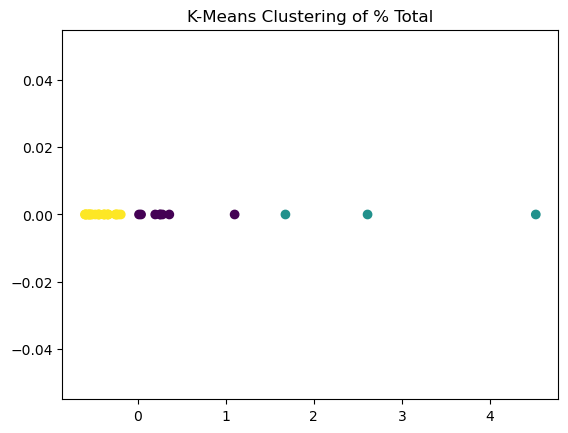

In [26]:
cluster = issues_per_country_non_opt.copy()

# Select the column for clustering
X = cluster[['Total']]

# Standardize the data (important for k-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=32)
cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Display the DataFrame with cluster assignments
display(cluster.sort_values(by='Total', ascending=False))

# Plot the clusters
plt.scatter(X_scaled[:, 0], [0] * len(X_scaled), c=cluster['cluster'], cmap='viridis')
plt.title('K-Means Clustering of % Total')
plt.show()

In [27]:
# Get a list of unique country and year combinations where 'id' is not null
not_null_id_combinations = df_part_3b.loc[~df_part_3b['ID number (if applicable)'].isnull(), ['Country', 'Year']].drop_duplicates()

# Display the result
print(not_null_id_combinations)


                Country    Year
0           Afghanistan  2018.0
5           Afghanistan  2019.0
10          Philippines  2018.0
52         Burkina Faso  2017.0
96                 Chad  2017.0
106                Chad  2018.0
117       Cote d'Ivoire     NaN
126       Cote d'Ivoire  2018.0
149  Dominican Republic  2018.0
154  Dominican Republic  2019.0
158  Dominican Republic  2020.0
261           Guatemala  2017.0
267              Guyana  2018.0
274                Iraq  2017.0
291             Liberia  2018.0
296             Liberia  2019.0
348              Mexico  2018.0
351            Mongolia  2018.0
385          Mozambique  2019.0
386             Myanmar  2018.0
396             Nigeria  2017.0
405             Nigeria  2018.0
414              Norway  2017.0
418              Norway  2018.0
422              Norway  2019.0
436             Senegal  2018.0
457          Seychelles  2017.0
464            Suriname  2017.0
480                Togo  2017.0
504             Ukraine  2017.0
507     